In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
'''
gTTS - (Google Text-to-Speech)is a Python library and CLI tool to interface with Google Translate text-to-speech API.

playsound - The playsound module is a cross platform module that can play audio files.
'''
!pip install gtts
!pip install playsound
!pip install ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=11b0a9b534d3e8bb6d7d264d04ecb1fa0fc409ce29beb002cab80ed98cd380f5
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import all the required libraries

import os                   # Pathname manipulation
import glob                 # For pattern matching of pathnames
import time                 # Provides functions related to time values
import random               # To generate random numbers
import re                   # Regular expressions
from tqdm import tqdm       # Used for creating Progress Meters or Progress Bars ('taqaddum' in arabic for progress)
# Module provides additional data structures for collections of data like defaultdict, ordereddict, counter, Deque, Namedtuple, Chainmap
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

# PIL - Python Imaging Library, adds many image processing features
from PIL import Image
from skimage import io

from sklearn.model_selection import train_test_split

#model building
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras import Input, layers
from keras import optimizers

from gtts import gTTS
from playsound import playsound
from IPython import display

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [ ]:
#Importing the dataset and reading the image into a seperate variable
#!ls "/content/drive/My Drive"
#!ls "/content/drive/MyDrive/data"
images_folder_path = '/content/drive/MyDrive/data/Images.zip (Unzipped Files)'
# alternative code> images_folder_path = os.path.join('/','kaggle','input','flickr8k','Images')

captions_file_path = '/content/drive/MyDrive/data/captions.txt'
# alternative code> captions_file_path = '/kaggle/input/flickr8k/captions.txt'

working_folder_path = '/content/drive/MyDrive/data'
#working_folder_path = os.path.join('/','kaggle','working')

# Creating a list which contains the path to the images
all_imgs_path_list = glob.glob(images_folder_path + '/*.jpg',recursive=True)

print("The total images present in the dataset: ", len(all_imgs_path_list))

The total images present in the dataset:  8091


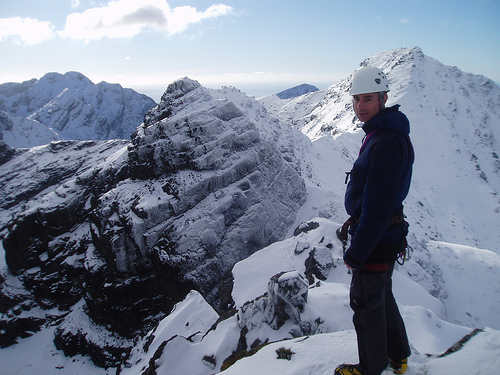

In [ ]:
#Visualising both the images & text present in the dataset

# Visualizing a random image
# Random image index
random_img_index = np.random.randint(low=0, high=len(all_imgs_path_list)-1, size=None, dtype=int)
Image.open(all_imgs_path_list[random_img_index])

In [ ]:
#Importing the dataset and read the text file into a seperate variable

def load_doc(filename):

    text=open(filename).read()
    return text

doc = load_doc(captions_file_path)
print(doc[:500])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


In [ ]:
captions_df = pd.read_csv(captions_file_path) # Creating a captions dataframe with comma seperated values of images & captions

print("Total captions present in the dataset: ", len(list(captions_df.caption)))
print("Total images present in the dataset: ",len(all_imgs_path_list))

captions_df.head()

Total captions present in the dataset:  40455
Total images present in the dataset:  8091


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
all_img_id = list(captions_df.image)    # store all the image id here as list
all_img_vector = all_imgs_path_list     # store all the image path here as list
annotations = list(captions_df.caption) # store all the captions here as list

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['Image-ID','Path', 'Captions'])
# df is dataframe containing image-id, image path and caption
df.head(10)

Image-ID  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                                Path  \
0  /content/drive/MyDrive/data/Images.zip (Unzipp...   
1  /content/drive/MyDrive/data/Images.zip (Unzipp...   
2  /content/drive/MyDrive/data/Images.zip (Unzipp...   
3  /content/drive/MyDrive/data/Images.zip (Unzipp...   
4  /content/drive/MyDrive/data/Images.zip (Unzipp...   
5  /content/drive/MyDrive/data/Images.zip (Unzipp...   
6  /content/drive/MyDrive/data/Images.zip (Unzipp...   
7  /content/drive/MyDrive/data/Images.zip (Unzipp...   
8  /content/drive/MyDrive/data/Images.zip (Unzipp...   
9  /content/drive/MyDrive/data/Images.zip (Unzipp...   

                                            Captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [ ]:
# Adding the <start> & <end> token to all those captions as well

start_token = '<start>'
end_token = '<end>'

image_path_to_caption = defaultdict(list) # Dictionary with key: image id, values: list of 5 captions

for idx, row in captions_df.iterrows():
    caption = f'{start_token} {row.caption} {end_token}' # adding <start> & <end> token for each caption
    image_path = os.path.join(images_folder_path,row.image) # image_path contains list of image paths
    image_path_to_caption[image_path].append(caption) # Generates dictionary of image_path: caption

In [ ]:
# image_path_to_caption

['<start> A bearded man and a bald man carrying prizes at a carnival . <end>', '<start> A man holding plastic toys looks away while a man wearing a white hat smiles at the camera . <end>', '<start> Two bearded men at a fair . <end>', '<start> Two men one with a beard at a carnival . <end>', '<start> Two men standing in front of an amusement park ride <end>']


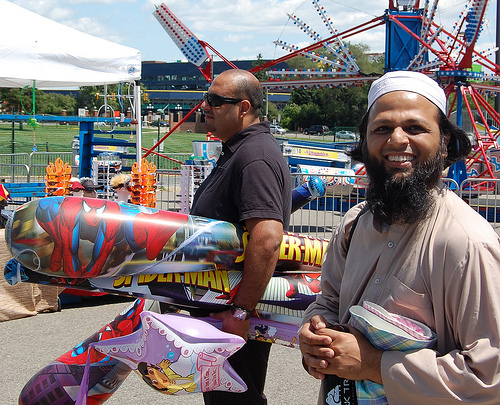

In [ ]:
# Visualizing a random image and its captions

image_num = np.random.randint(low=0, high=len(all_imgs_path_list)-1, size=None, dtype=int)
print(list(image_path_to_caption.values())[image_num])
Image.open(list(image_path_to_caption.keys())[image_num])

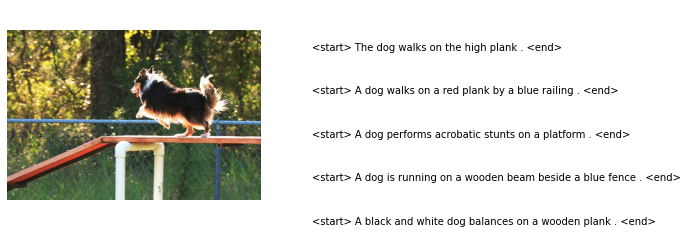

In [ ]:
# Visualizing image and corresponding captions

img_path_from_dict = list(image_path_to_caption.keys())
all_captions = []  # Caption list containing captions with start & end token for all the images
img_name_vector = [] # Creating image path list (ordered based on caption sets of 5, captions with start & end token)

for img_path in img_path_from_dict:

    # Caption list containing 5 captions with start & end token corresponding to a single image
    caption_list = image_path_to_caption[img_path]

    # Caption list containing captions with start & end token for all images
    all_captions.extend(caption_list)

    # Creating image path list (ordered based on caption sets of 5, captions with start & end token)
    img_name_vector.extend([img_path] * len(caption_list))

# random image index
image_num = np.random.randint(low=0, high=len(all_imgs_path_list)-1, size=None, dtype=int)
image_num = image_num//5
image_num = image_num*5

f, axes = plt.subplots(1, 2)
plt.axis('off')
f.set_figwidth(10)
axes[0].imshow(io.imread(img_name_vector[image_num]))
axes[0].axis('off')
axes[1].set_ylim(0,5)
for i in range(0,5):
    axes[1].text(0,i,all_captions[i+image_num])

In [ ]:
# Creating the vocabulary & the counter for the captions

vocabulary= [word.lower() for line in annotations for word in line.split()]

val_count=Counter(vocabulary)

In [ ]:
# val_count

       Word  Count
0         a  62986
1         .  36577
2        in  18974
3       the  18418
4        on  10743
5        is   9345
6       and   8851
7       dog   8136
8      with   7765
9       man   7265
10       of   6713
11      two   5638
12    white   3940
13    black   3832
14      boy   3581
15      are   3504
16    woman   3402
17     girl   3328
18        ,   3232
19       to   3173
20  wearing   3062
21       at   2914
22   people   2883
23    water   2783
24      red   2672
25    young   2630
26    brown   2563
27       an   2432
28      his   2357
29     blue   2268


Text(0, 0.5, 'Count')

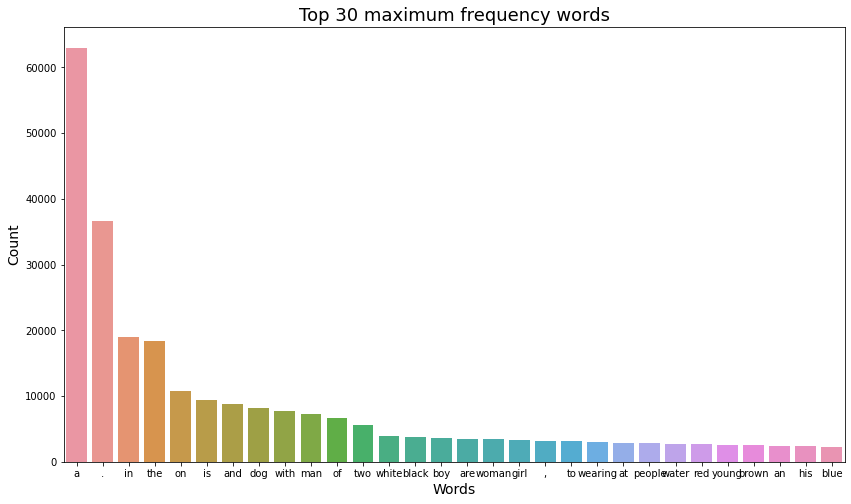

In [ ]:
# Visualising the top 30 occuring words in the captions

top30_words_countwise = val_count.most_common(30)
top30_words_df = pd.DataFrame(top30_words_countwise, columns = ['Word', 'Count'])
print(top30_words_df)

fig = plt.figure(figsize=(14,8))
sns.barplot(x='Word', y='Count', data = top30_words_df)
plt.title("Top 30 maximum frequency words", fontsize = 18)
plt.xlabel("Words", fontsize = 14)
plt.ylabel("Count", fontsize = 14)

In [ ]:
# creating the tokenizer

# Top 5000 words
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# annotations =  list of all captions
# fit_on_texts >> Updates internal vocabulary based on a list of texts, in case of texts containing lists, each entry of the lists is assumed to be a token.
# Required before using `texts_to_sequences`
tokenizer.fit_on_texts(all_captions)
# Transforms each text in texts to a sequence of integers
tokenized_text_sequence = tokenizer.texts_to_sequences(all_captions)
tokenized_text_sequence[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [ ]:
# Creating word-to-index and index-to-word mappings.

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
tokenized_text_sequence = tokenizer.texts_to_sequences(all_captions)
tokenized_text_sequence[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [ ]:
random_index = np.random.randint(low=0, high=len(all_imgs_path_list)-1, size=None, dtype=int)
print(all_captions[random_index])
print(tokenized_text_sequence[random_index])

<start> two bikers bike along the street . <end>
[3, 14, 963, 80, 114, 6, 73, 4]


In [ ]:
# Creating a word count of your tokenizer to visulize the Top 30 occuring words after text processing

dict_word_count = tokenizer.word_counts

In [ ]:
# dict_word_count

       Word  Count
0         a  62992
1   <start>  40455
2     <end>  40455
3        in  18986
4       the  18419
5        on  10745
6        is   9345
7       and   8862
8       dog   8138
9      with   7765
10      man   7274
11       of   6723
12      two   5642
13    white   3959
14    black   3848
15      boy   3581
16      are   3504
17    woman   3402
18     girl   3328
19       to   3176
20  wearing   3062
21       at   2915
22   people   2883
23    water   2790
24      red   2691
25    young   2630
26    brown   2578
27       an   2432
28      his   2357
29     blue   2279


Text(0, 0.5, 'Count')

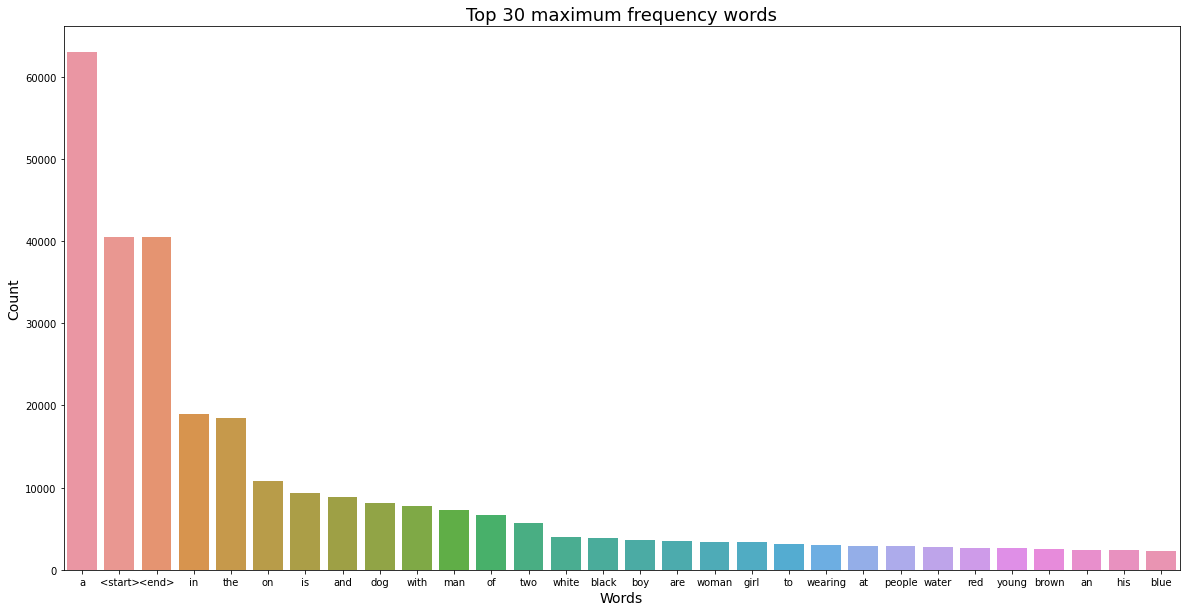

In [ ]:
# Visualising the top 30 occuring words in the captions after text processing

tokenized_word_count = sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)
tokenized_word_count_df = pd.DataFrame(tokenized_word_count, columns = ['Word', 'Count'])
top30_tokenized_words_df = tokenized_word_count_df.iloc[0:30,:]
print(top30_tokenized_words_df)

fig = plt.figure(figsize=(20,10))
sns.barplot(x='Word', y='Count', data = top30_tokenized_words_df)
plt.title("Top 30 maximum frequency words", fontsize = 18)
plt.xlabel("Words", fontsize = 14)
plt.ylabel("Count", fontsize = 14)

In [ ]:
# all_captions - all captions list including start & end token
all_tokenized_text_sequence = tokenizer.texts_to_sequences(all_captions)

max_length_caption = max(len(i) for i in all_tokenized_text_sequence)
print('Maximum length of any caption in the dataset: ', max_length_caption)

Maximum length of any caption in the dataset:  39


In [ ]:
# Padding each vector to the max_length of the captions ^ store it to a vairable

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(all_tokenized_text_sequence, padding = 'post',maxlen = max_length_caption)

print("The shape of Caption vector is :" + str(cap_vector.shape))
cap_vector[1:3,:]

The shape of Caption vector is :(40455, 39)


array([[   3,    2,   20,  317,   65,    2,  197,  118,    4,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   3,    2,   41,   20,  120,   65,    2,  197, 2438,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

In [ ]:
# Creating the function which returns images & their path

def load_image(image_path):
    #write your pre-processing steps here
    preprocessed_img = tf.io.read_file(image_path)
    preprocessed_img = tf.image.decode_jpeg(preprocessed_img, channels=3)
    preprocessed_img = tf.image.resize(preprocessed_img, (299, 299))
    # tf.keras.applications.inception_v3.preprocess_input will normalize input to range of -1 to 1
    preprocessed_img = tf.keras.applications.inception_v3.preprocess_input(preprocessed_img)
    return preprocessed_img, image_path

In [ ]:
# Applying the function to the image path dataset, such that the transformed dataset would contain images & their path

encode_train_set = sorted(set(img_name_vector))    # img_name_vector - path list of all images according to caption set with start & end token

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
image_data_set

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input                    #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output     #write code here to get the output of the image_model

image_features_extract_model = keras.Model(new_input, hidden_layer)   #build the final model using both input & output layer

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
# Applying the feature_extraction model to earlier created dataset which contained images & their respective paths

feature_dict = {}

# using tqdm for progress bar
for image,path in tqdm(image_data_set):

    # feed images from newly created Dataset above to Inception V3 built above
    batch_features = image_features_extract_model(image)

    # To squeeze out the features in a batch, to reshape features in order of (batch_size, 8*8, 2048)
    batch_features_reshaped = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for batch_f, p in zip(batch_features_reshaped, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [48:25<00:00, 11.48s/it]


In [ ]:
image_data_set

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
# batch_features

In [ ]:
# batch_features_reshaped

In [ ]:
print('Shape of batch_features - ',batch_features.shape)
print('Shape of batch_features_reshaped - ',batch_features_reshaped.shape)
print('Shape of feature extracted for an image',batch_f.shape)

Shape of batch_features -  (27, 8, 8, 2048)
Shape of batch_features_reshaped -  (27, 64, 2048)
Shape of feature extracted for an image (64, 2048)


In [ ]:
# Applying train_test_split on both image path & captions to create the train & test list.
# Creating the train-test spliit using 80-20 ratio & random state = 42

path_train, path_test, cap_train, cap_test = train_test_split(img_name_vector, cap_vector, test_size=0.2, random_state=42)
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [ ]:
# Creating a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_name,capt):
  image_tensor = feature_dict[image_name.decode('utf-8')]    # Code to extract the features from the dictionary stored earlier
  return image_tensor,capt

In [ ]:
# creating a builder function to create dataset which takes in the image path & captions as input
# This function would transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

BATCH_SIZE = 32
BUFFER_SIZE = 1000
def gen_dataset(images_data, captions_data):

    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


In [ ]:
# Setting the parameters

embedding_dim = 256
units = 512
vocab_size = 5001   #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

In [ ]:
class Encoder(Model):
    def __init__(self,embedding_dim):
        super(Encoder, self).__init__()
        self.dense = layers.Dense(embedding_dim)       #build your Dense layer with relu activation

    def call(self, features, training=False):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = self.dense(features)
        features = tf.nn.relu(features)
        return features

In [ ]:
encoder=Encoder(embedding_dim)

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)       #build Dense layer
        self.W2 = layers.Dense(units)       #build Dense layer
        self.V = layers.Dense(1)            #build final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)

        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)

        # build the score funciton to shape: (batch_size, 8*8, units)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # extract the attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = keras.activations.softmax(self.V(score), axis=1)

        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features

        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)                # iniitalise the Attention model with units
        self.embed = layers.Embedding(vocab_size, embedding_dim)    # build the Embedding layer
        self.gru = layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)              # build the Dense layer
        self.d2 = layers.Dense(vocab_size)              # build the Dense layer

    def call(self,x,features, hidden):
        #create the context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        # embed the input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        # Concatenate the input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output,state = self.gru(embed)
        output = self.d1(output)
        # shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # shape : (batch_size * max_length, vocab_size)
        output = self.d2(output)

        return output, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


In [ ]:
LR = 2e-4
optimizer = tf.keras.optimizers.Adam(learning_rate = LR)         #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none')   #define the loss object

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = os.path.join(working_folder_path,'checkpoint')
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss/int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))


    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    # Code to get the average loss result on our test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps

    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.353, & test loss is 1.129
Time taken for 1 epoch 270.41402673721313 sec

Test loss has been reduced from 100.000 to 1.129


  7%|▋         | 1/15 [04:31<1:03:15, 271.13s/it]

For epoch: 2, the train loss is 1.048, & test loss is 1.005
Time taken for 1 epoch 126.24861216545105 sec

Test loss has been reduced from 1.129 to 1.005


 13%|█▎        | 2/15 [06:37<40:19, 186.13s/it]  

For epoch: 3, the train loss is 0.960, & test loss is 0.937
Time taken for 1 epoch 125.30915594100952 sec

Test loss has been reduced from 1.005 to 0.937


 20%|██        | 3/15 [08:43<31:42, 158.52s/it]

For epoch: 4, the train loss is 0.905, & test loss is 0.889
Time taken for 1 epoch 123.93812417984009 sec

Test loss has been reduced from 0.937 to 0.889


 27%|██▋       | 4/15 [10:47<26:35, 145.05s/it]

For epoch: 5, the train loss is 0.862, & test loss is 0.848
Time taken for 1 epoch 123.24688935279846 sec

Test loss has been reduced from 0.889 to 0.848


 33%|███▎      | 5/15 [12:51<22:53, 137.33s/it]

For epoch: 6, the train loss is 0.824, & test loss is 0.813
Time taken for 1 epoch 122.46547484397888 sec

Test loss has been reduced from 0.848 to 0.813


 40%|████      | 6/15 [14:54<19:52, 132.44s/it]

For epoch: 7, the train loss is 0.792, & test loss is 0.783
Time taken for 1 epoch 122.16404342651367 sec

Test loss has been reduced from 0.813 to 0.783


 47%|████▋     | 7/15 [16:56<17:13, 129.20s/it]

For epoch: 8, the train loss is 0.764, & test loss is 0.756
Time taken for 1 epoch 123.5003833770752 sec

Test loss has been reduced from 0.783 to 0.756


 53%|█████▎    | 8/15 [19:00<14:52, 127.53s/it]

For epoch: 9, the train loss is 0.738, & test loss is 0.731
Time taken for 1 epoch 123.70740509033203 sec

Test loss has been reduced from 0.756 to 0.731


 60%|██████    | 9/15 [21:04<12:38, 126.45s/it]

For epoch: 10, the train loss is 0.715, & test loss is 0.708
Time taken for 1 epoch 123.05192875862122 sec

Test loss has been reduced from 0.731 to 0.708


 67%|██████▋   | 10/15 [23:08<10:27, 125.55s/it]

For epoch: 11, the train loss is 0.692, & test loss is 0.687
Time taken for 1 epoch 123.24300527572632 sec

Test loss has been reduced from 0.708 to 0.687


 73%|███████▎  | 11/15 [25:12<08:19, 124.97s/it]

For epoch: 12, the train loss is 0.672, & test loss is 0.666
Time taken for 1 epoch 123.00853729248047 sec

Test loss has been reduced from 0.687 to 0.666


 80%|████████  | 12/15 [27:15<06:13, 124.51s/it]

For epoch: 13, the train loss is 0.652, & test loss is 0.648
Time taken for 1 epoch 168.3515326976776 sec

Test loss has been reduced from 0.666 to 0.648


 87%|████████▋ | 13/15 [30:04<04:35, 137.91s/it]

For epoch: 14, the train loss is 0.634, & test loss is 0.628
Time taken for 1 epoch 125.92513990402222 sec

Test loss has been reduced from 0.648 to 0.628


 93%|█████████▎| 14/15 [32:10<02:14, 134.44s/it]

For epoch: 15, the train loss is 0.616, & test loss is 0.615
Time taken for 1 epoch 125.64152836799622 sec

Test loss has been reduced from 0.628 to 0.615


100%|██████████| 15/15 [34:16<00:00, 137.12s/it]


No handles with labels found to put in legend.


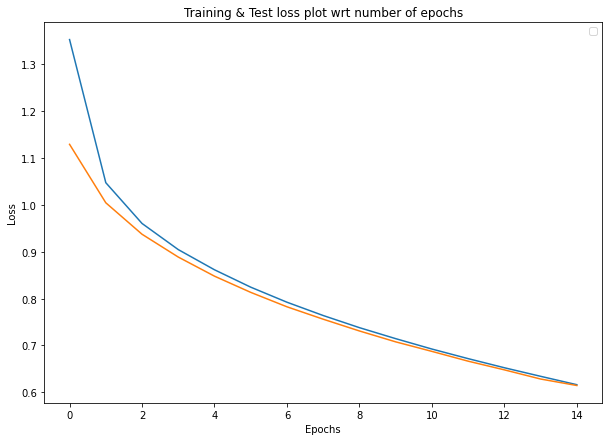

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Test loss plot wrt number of epochs')
plt.legend()
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length_caption, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)  # process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)        # Extracting features using feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)       # extracting the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length_caption):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)    # getting the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.argmax(predictions[0]).numpy()
        # map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [ ]:
def beam_evaluate(image, beam_index = 3):#your value for beam index):

    # to evaluate the result using beam search
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length_caption, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length_caption:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])

    return final_caption

In [ ]:
def plot_attention_map(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
def caption_prediction(autoplay=False, weights=(0.5, 0.5, 0, 0)):
    rid = np.random.randint(0, len(path_test))
    test_image = path_test[rid]
    test_image = '/content/IMG_20191207_075149.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)


    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights = weights)     #set your weights)
    print(f"BELU score: {score*100}")

    print('Real Caption:', real_caption)
    print(f"Prediction Caption: {pred_caption}")
    plot_attention_map(result, attention_plot, test_image)

    # we make use of Google Text to Speech API (online), which will convert the caption to audio
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return Image.open(test_image)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 50.984479138794214
Real Caption: two young children on a skateboard going across a sidewalk
Prediction Caption: two young children are sitting on a skateboard


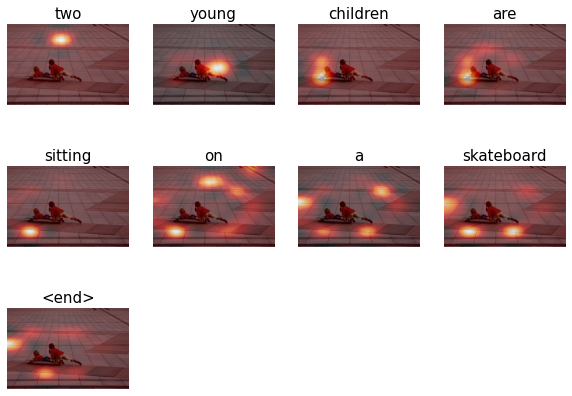

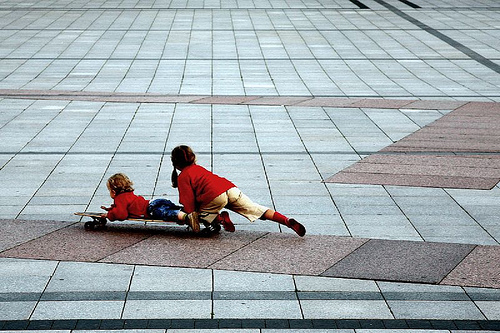

In [ ]:
caption_prediction(autoplay=True, weights=(0.5, 0.5, 0, 0))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

BELU score: 6.710192188209129e-76
Real Caption: a couple in old clothing at an outdoor table
Prediction Caption: a man and woman in front fur


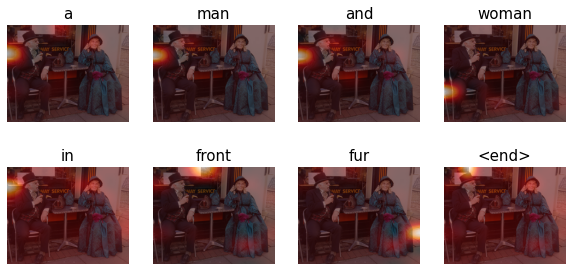

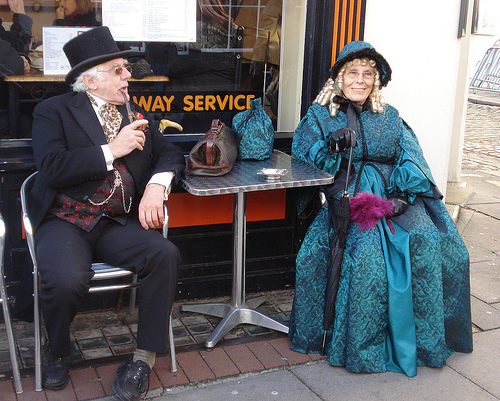

In [ ]:
caption_prediction(autoplay=True, weights=(0.25, 0.25, 0, 0))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 2.257368472960575e-276
Real Caption: a woman in a river is shaking her hair causing a water to spray everywhere
Prediction Caption: a woman is standing in the water


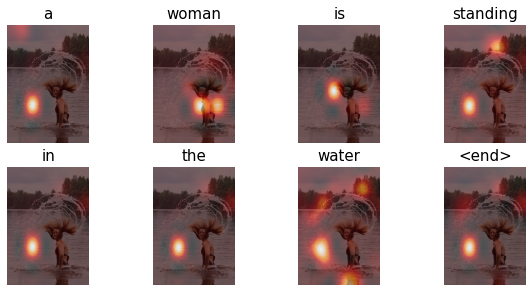

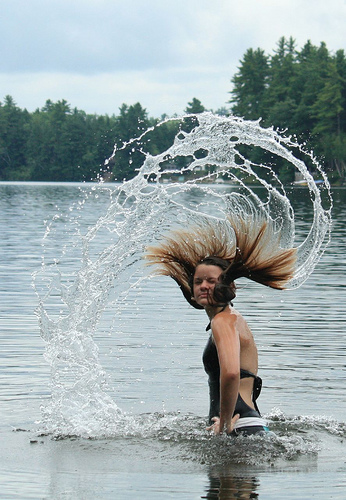

In [ ]:
caption_prediction(autoplay=True, weights=(0.2, 0.3, 0.4, 0.5))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 3.668922300336043e-153
Real Caption: a child is jumping from a swing and is in midair
Prediction Caption: a child jumps off a swing


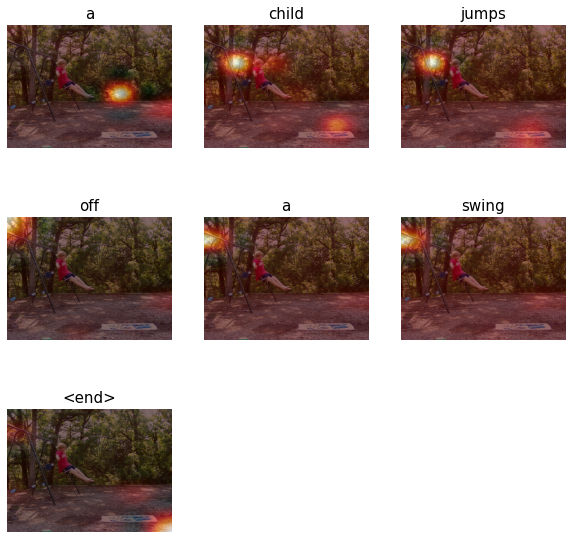

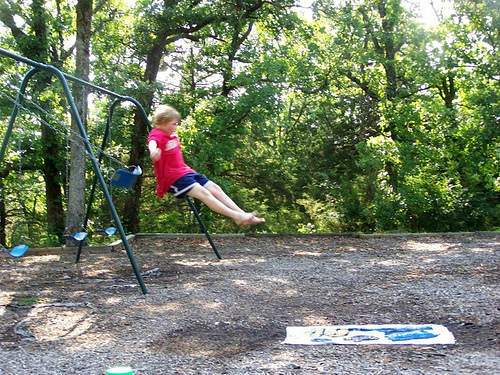

In [ ]:
caption_prediction(autoplay=True, weights=(0.5, 0.4, 0.3, 0.2))

BELU score: 30.81980909598119
Real Caption: an individual rappelling down a cliff towards the water
Prediction Caption: a man rappelling down a cliff


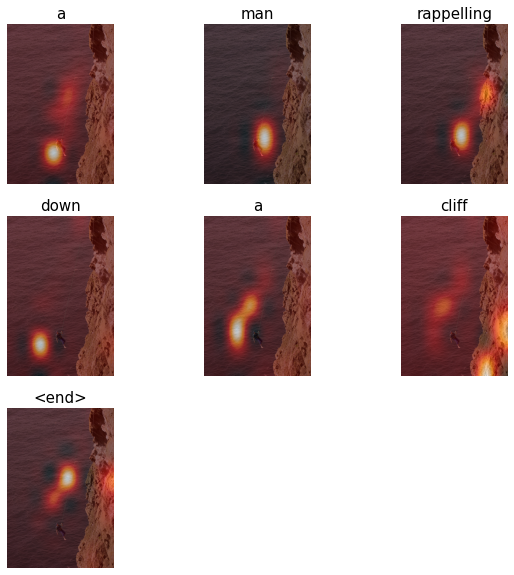

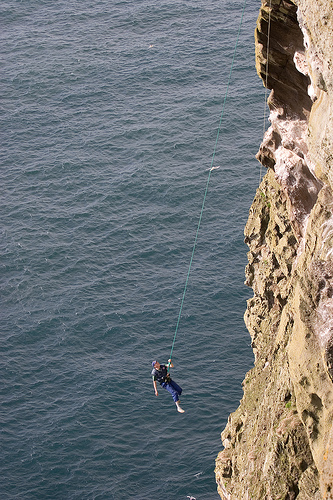

In [ ]:
caption_prediction(autoplay=True, weights=(0.25, 0.25, 0.25, 0.25))

BELU score: 13.190035683919174
Real Caption: a group of people peering over the edge of a large rocky mountain
Prediction Caption: a group of people are sitting on top of a mountain


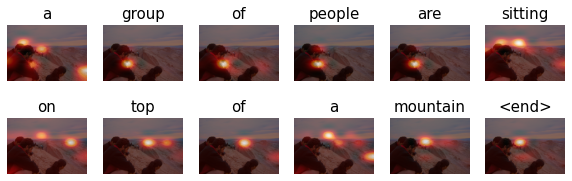

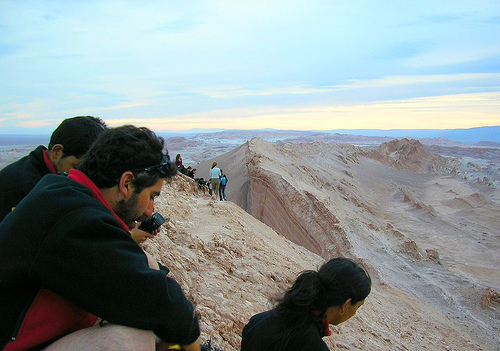

In [ ]:
caption_prediction(autoplay=True, weights=(0.3, 0.3, 0.4, 0.4))